# Model Data to Predict Subreddit Categories

In [270]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

## Read in reddit data gathered in Climbing_Yoga notebook

In [271]:
df1 = pd.read_csv('./reddit_data/reddit_climb_yoga.csv',index_col=0)
df2 = pd.read_csv('./reddit_data/reddit_climb_yoga_2.csv',index_col=0)
df3 = pd.read_csv('./reddit_data/reddit_climb_yoga_3.csv',index_col=0)
df4 = pd.read_csv('./reddit_data/reddit_climb_yoga_4.csv',index_col=0)
df5 = pd.read_csv('./reddit_data/reddit_climb_yoga_5.csv',index_col=0)

#### Read in df5 as additional data to test

In [272]:
#df5 = df5.drop_duplicates()

In [273]:
df5.shape

(800, 3)

In [274]:
df5.columns

Index(['title', 'selftext', 'subreddit'], dtype='object')

In [275]:
df5['subreddit'].value_counts()

yoga        400
climbing    400
Name: subreddit, dtype: int64

#### Combine df1 -df4 in one to train and test model

In [276]:
df4.head()

,title,selftext,subreddit
0,Care about Indian Creek? Public comment period...,This includes management of desert splitter pa...,climbing
1,"Friday New Climber Thread for August 31, 2018:...",Please sort comments by 'new' to find question...,climbing
2,I got stood up for a date at a climbing facili...,"Yesterday, I went to an indoor climbing facili...",climbing
3,Setting up for the second pitch of “I wanna go...,NaN,climbing
4,Adam Ondra in the Rockies series pulled becaus...,NaN,climbing


In [277]:
df = df1.append(df2)

In [278]:
df = df.append(df3)

In [279]:
df = df.append(df4)

In [280]:
df.shape

(2763, 3)

In [281]:
df=df.drop_duplicates()

In [282]:
df.shape

(1519, 3)

In [283]:
df = df.reset_index()

In [284]:
df = df.drop('index',axis=1)

In [285]:
df.head()

,title,selftext,subreddit
0,Care about Indian Creek? Public comment period...,This includes management of desert splitter pa...,climbing
1,"Friday New Climber Thread for August 24, 2018:...",Please sort comments by 'new' to find question...,climbing
2,Met this guy at my local climbing gym,NaN,climbing
3,Belaying my friend up my favourite climb Holey...,NaN,climbing
4,Been getting into climbing again and bought my...,NaN,climbing


In [286]:
#Data shape for selftext not null. 
selftext_nan = df['selftext'].isnull()
df[~selftext_nan].count()

title        929
selftext     929
subreddit    929
dtype: int64

#### Replace NaNs <br>
with text string 'n/a', so as not to loose useful title records to analyze (since there are 590 NaNs, approx. 1/3 of the data)

In [287]:
df['selftext'] = df['selftext'].replace(np.nan, "n/a")

In [288]:
df.shape

(1519, 3)

#### Add title length and selftext length features

In [289]:
df['title_len'] = df['title'].map(lambda x: len(x))

In [290]:
df['selftext_len']= df['selftext'].map(lambda x: len(x))
#notes that the only selftext lenghts of 3 are n/a

In [291]:
three_len = df['selftext_len']==3
st_na = df['selftext']=='n/a'
df[three_len & st_na].shape

(590, 5)

In [292]:
df.head()

,title,selftext,subreddit,title_len,selftext_len
0,Care about Indian Creek? Public comment period...,This includes management of desert splitter pa...,climbing,101,480
1,"Friday New Climber Thread for August 24, 2018:...",Please sort comments by 'new' to find question...,climbing,87,793
2,Met this guy at my local climbing gym,n/a,climbing,37,3
3,Belaying my friend up my favourite climb Holey...,n/a,climbing,57,3
4,Been getting into climbing again and bought my...,n/a,climbing,124,3


In [293]:
climb = df['subreddit'] =="climbing"
yog = df['subreddit']=="yoga"

In [307]:
print( "Avg length climb title:", df[climb]['title_len'].sum()/df[climb]['title_len'].count())
print( "Avg length yoga selftext:", df[yog]['title_len'].sum()/df[yog]['title_len'].count())
print( "Avg length climb selftext:", df[climb]['selftext_len'].sum()/df[climb]['selftext_len'].count())
print( "Avg length yoga selftext:", df[yog]['selftext_len'].sum()/df[yog]['selftext_len'].count())
print( "Avg length yoga selftext, outliers removed:",(df[yog]['selftext_len'].sum()-6724-6923)/(df[yog]['selftext_len'].count()-2))

Avg length climb title: 53.43516209476309
Avg length yoga selftext: 51.19944211994421
Avg length climb selftext: 231.0847880299252
Avg length yoga selftext: 465.68619246861925
Avg length yoga selftext, outliers removed: 447.9020979020979


In [308]:
df[yog].describe()

,title_len,selftext_len
count,717.000000,717.000000
mean,51.199442,465.686192
std,42.023013,575.933777
min,8.000000,3.000000
25%,27.000000,73.000000
50%,40.000000,346.000000
75%,58.000000,624.000000
max,300.000000,6923.000000


In [309]:
long_yog= df['selftext_len']>2000
df[long_yog & yog]['selftext_len']

27     6724
32     2325
185    2310
276    2429
416    2025
431    2545
432    2184
488    2196
529    2612
667    2947
684    2034
688    6923
Name: selftext_len, dtype: int64

In [310]:
#df.loc[660,'selftext']

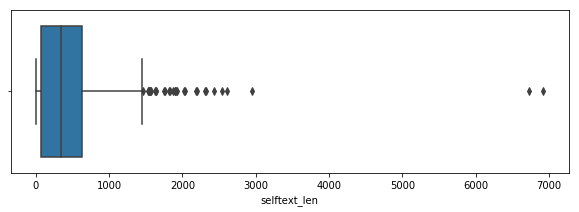

In [323]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
sns.boxplot(df[yog]['selftext_len']);

Whiles titles of each subreddit have a similar average length, the body of yoga post are, on average, twice as long, so subreddit length may be a metric to consider to help predict subreddit categories.

#### Lemmatize words in title and subreddit categories

In [324]:
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords

In [325]:
def lem_process(text):
    tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)') #remove punctuation
    tokens = tokenizer.tokenize(text)
    new_tokens = [i[0] for i in tokens]

    #Lemmatize
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(i) for i in new_tokens]
    
    return " ".join(lem_tokens) #stick the words back together for each item

In [326]:
lem_process(df.loc[129,'selftext'])

'Climbing is a strange For me it is purely a hobby I am not even a good climber by any mean not internationally not locally not at my gym and not even among my friend however it is still a big part of my life and my identity This ha led to numerous problem for example fear of failure and even unhealthy amount of time spent climbing or training for climbing to the point where I would feel frustrated to skip a training session to have a beer with friend This book will adrress many such problem and way to overcome these crippling habit I want to improve my climbing I also want to have a healthier relationship with my favorite activity and I want to have more fun and le negative emotioms and thought when I am out climbimg so I had a very open mind while reading this book hence it reflected greatly to me I found many area to fix on my approach to climbing and life in general with great tip and advice how to achieve that It is absolutelly great read that I would recommend to pretty much ever

In [327]:
#df['title'] = df['title'].map(lambda x: lem_process(x))

In [328]:
#df['selftext'] = df['selftext'].map(lambda x: lem_process(x))

In [329]:
def port_stemmer(text):
        tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)') #remove punctuation
        tokens = tokenizer.tokenize(text)
        new_tokens = [i[0] for i in tokens]
        
        p_stemmer = PorterStemmer()
        port_tokens = [p_stemmer.stem(i) for i in new_tokens]
        return " ".join(port_tokens)

In [330]:
text2 = df.loc[129,'selftext']
text2

"Climbing is a strange. For me it is purely a hobby, I am not even a good climber by any means, not internationally, not locally, not at my gym and not even among my friends, however it is still a big part of my life and my identity. This has led to numerous problems, for example fear of failure and even unhealthy amount of time spent climbing or training for climbing, to the point where I would feel frustrated to skip a training session to have a beer with friends.\n\nThis book will adrress many such problems and ways to overcome these crippling habits. I want to improve my climbing, I also want to have a healthier relationship with my favorite activity and I want to have more fun and less negative emotioms and thoughts when I am out climbimg, so I had a very open mind while reading this book hence it reflected greatly to me. I found many areas to fix on my approach to climbing and life in general with great tips and advices how to achieve that.\n\nIt is absolutelly great read that I 

In [331]:
def eng_stemmer(text):
        tokenizer = RegexpTokenizer(r'(\$?(\d+[\.,]?)+%?|(\/?\w+)+)') #remove punctuation
        tokens = tokenizer.tokenize(text)
        new_tokens = [i[0] for i in tokens]
        
        s_stemmer = EnglishStemmer()
        eng_tokens = [s_stemmer.stem(i) for i in new_tokens]
        
        return " ".join(eng_tokens)

In [332]:
eng_stemmer(text2)

'climb is a strang for me it is pure a hobbi i am not even a good climber by ani mean not intern not local not at my gym and not even among my friend howev it is still a big part of my life and my ident this has led to numer problem for exampl fear of failur and even unhealthi amount of time spent climb or train for climb to the point where i would feel frustrat to skip a train session to have a beer with friend this book will adrress mani such problem and way to overcom these crippl habit i want to improv my climb i also want to have a healthier relationship with my favorit activ and i want to have more fun and less negat emotiom and thought when i am out climbimg so i had a veri open mind while read this book henc it reflect great to me i found mani area to fix on my approach to climb and life in general with great tip and advic how to achiev that it is absolutelli great read that i would recommend to pretti much everyon who is will to improv their live or athlet perform this is a cl

In [333]:
text3 = df.loc[162,'selftext']
eng_stemmer(text3)

'i work at a climb gym and have taught beginn lesson and coach kid climb team for a littl over two year now i ve also read numer book on train and done train program myself howev recent i taught a privat lesson for a person that i just describ in the titl and it s a littl difficult for me becaus he is not abl to do the same exercis that kid or young adult are typic abl to do at a beginn level so far i ve had him do pull up use an assist pull up machin take off a lot of weight and done some relat easi core work like knee rais becaus he can t do sit up or russian twist or anyth like that he know a good deal of techniqu but most of the time he doesn t have the confid in himself to tri thing that i suggest while he s climb on the wall so i think that if his strength is increas he will have more confid in himself while climb the onli problem is that the supplement exercis that i m use to are too difficult for him do you guy know of ani exercis he or other peopl like him mayb overweight peop

In [334]:
long_climb = df['selftext_len']>1000

In [335]:
df[climb & long_climb].head(10)

,title,selftext,subreddit,title_len,selftext_len
54,"Forearm popped, no pain though",So I was turning around a corner. My left arm ...,climbing,30,1124
59,Finger pain: when is it fine to keep climbing ...,"Coming from a few years of body building, I kn...",climbing,94,1071
62,Wedding Gift: Top 3 greatest climbing area books?,"Hello friends of r/climbing!\n\ntl:dr, I’m buy...",climbing,49,1593
73,Shoulder Dislocation Bouldering,"\n\nHi guys,\n\nIn 2015 I dislocated my shou...",climbing,31,1653
76,Too old for this?,I learned the basics of climbing when I was 17...,climbing,17,1007
108,Rock Over Climbing reopening on September 1st ...,"If you climb in or around Manchester, you've p...",climbing,56,1448
129,Verical mind: a book for climbers who stopped ...,Climbing is a strange. For me it is purely a h...,climbing,75,1398
144,Asian Games Women's Final recap,They started the day with speed. This was my f...,climbing,31,4143
147,Advice for building mind-body connection?,I've been a desk jockey my whole life. Due to ...,climbing,41,3250
162,"Any training tips for an older, not very stron...",I work at a climbing gym and have taught begin...,climbing,80,1191


Neither the Lemmatizer nor the PorterStemmer got climb/climbing/climber to be the same root word, but EnglishStemmer did. <br>It is a more brutal process but I choose to use the EnglisgStemmer in my models.

In [336]:
df['title'] = df['title'].map(lambda x: eng_stemmer(x))

In [337]:
df['selftext'] = df['selftext'].map(lambda x: eng_stemmer(x))

In [338]:
df['subreddit'].value_counts()

climbing    802
yoga        717
Name: subreddit, dtype: int64

In [339]:
df['subreddit'].value_counts(normalize=True)

climbing    0.527979
yoga        0.472021
Name: subreddit, dtype: float64

Since climbing and yoga posts each account for approximately 50% of the subreddit posts, we can say that we have relatively balanced classes (i.e. no correction for unbalanced classes is necessary). 

## NLP

#### Use CountVectorizer to vectorize words

In [341]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [342]:
df.columns

Index(['title', 'selftext', 'subreddit', 'title_len', 'selftext_len'], dtype='object')

#### Transform y to binary, 1 = climbing, 0 = yoga

In [343]:
y_cat = df['subreddit']
#Change y to binary
y_bin = [1 if i=='climbing' else 0 for i in y_cat]

In [344]:
X = df[['title','selftext','selftext_len']]
y = y_bin

#### Train Test Split

In [345]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [346]:
X_train.shape, X_test.shape

((1139, 3), (380, 3))

#### Transform text data to counts of frequency with CountVectorizer: 

a. Title feature:

In [347]:
cv = CountVectorizer(stop_words='english')
cv.fit(X_train['title'])
X_train_title_cv = cv.transform(X_train['title'])
X_test_title_cv = cv.transform(X_test['title'])

In [348]:
X_train_title_df = pd.DataFrame(X_train_title_cv.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [349]:
X_train_title_df.head()

,00,03,10,100,11,12,13,14,15,160,...,yoshiyuki,young,youth,youtub,ytt,zangerl,zone,ādiṣu,κnееlіng,ѕtаndіng
812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create custom stop words list for title feature by removing features that are numbers.

In [350]:
new_list_title = []
for i in X_train_title_df.columns:
    try:
        int(i)
        new_list_title.append(i)
    except:
        pass

In [351]:
print(new_list_title, "len:", len(new_list_title))

['00', '03', '10', '100', '11', '12', '13', '14', '15', '160', '17', '18', '19', '1922', '20', '200', '2005', '2009', '2013', '2017', '2018', '2019', '21', '22', '23', '24', '25', '29', '30', '31', '32', '35', '39', '40', '4200', '50', '501', '5600', '59', '60', '627', '70', '750', '85'] len: 44


In [352]:
custom_stop_words = stopwords.words('english')
custom_stop_words.extend(new_list_title)
custom_stop_words[-5:-1]

['60', '627', '70', '750']

#### Implement CountVectorizer on title features with tuned parameters: 

In [353]:
cv = CountVectorizer(stop_words=custom_stop_words,min_df=0.015)
cv.fit(X_train['title'])
X_train_title_cv = cv.transform(X_train['title'])
X_test_title_cv = cv.transform(X_test['title'])

In [354]:
X_train_title_df = pd.DataFrame(X_train_title_cv.todense(), columns=cv.get_feature_names(),index = X_train.index)

In [355]:
X_test_title_df = pd.DataFrame(X_test_title_cv.todense(), columns=cv.get_feature_names(),index = X_test.index)

In [356]:
X_train_title_df.head().T

,812,662,610,1220,1171
advic,0,0,0,0,0
ani,0,0,0,0,0
anyon,0,0,0,0,0
back,0,0,0,0,0
best,0,0,0,0,0
boulder,0,0,0,0,0
class,0,0,0,0,0
climb,0,0,0,0,1
climber,0,0,0,0,0
comp,0,0,0,0,0


In [357]:
X_test_title_df.shape

(380, 42)

#### Tune Body Title Vectorizer to only the top words (just for demonstration):

In [358]:
cv_top5 = CountVectorizer(stop_words=custom_stop_words,min_df=0.15)
cv_top5.fit(X_train['selftext'])
X_train_title_cv_top5 = cv_top5.transform(X_train['title'])
X_test_title_cv_top5 = cv_top5.transform(X_test['title'])

In [359]:
X_train_title_df_top5 = pd.DataFrame(X_train_title_cv_top5.todense(), columns=cv_top5.get_feature_names(),index = X_train.index)

In [394]:
#X_train_title_df_top5.sum()

In [396]:
top5_title_df =pd.DataFrame({'word':X_train_title_df_top5.columns,
                           'word_count':X_train_title_df_top5.sum()})
top5_title_df= top5_title_df.sort_values('word_count')
top5_title_df

,word,word_count
thank,thank,5
would,would,11
like,like,23
ani,ani,31
anyon,anyon,31
get,get,43
climb,climb,196
yoga,yoga,199


#### b. Body ('selftext') feature

In [423]:
cv2 = CountVectorizer(stop_words='english')
cv2.fit(X_train['selftext'])
X_train_body_cv = cv2.transform(X_train['selftext'])
X_test_body_cv = cv2.transform(X_test['selftext'])

In [424]:
X_train_body_df = pd.DataFrame(X_train_body_cv.todense(), columns=cv2.get_feature_names(),index=X_train.index)

In [425]:
X_train_body_df.head()

,00,10,100,1024,104,105716763,105717892,105756826,11,110,...,ywa,zen,zeni,zenith,zero,zest,zoe,zone,ztdbggkzk,zug
812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create custom stop words list for body (selftext feature) by removing features that are numbers

In [426]:
new_list_body = []
for i in X_train_body_df.columns:
    try:
        int(i)
        new_list_body.append(i)
    except:
        pass

In [427]:
print(new_list_body, "len:", len(new_list_body))

['00', '10', '100', '1024', '104', '105716763', '105717892', '105756826', '11', '110', '114338282', '1169', '12', '120', '13', '130', '14', '140', '140965', '141293', '145', '15', '150', '1547699', '16', '160', '17', '171', '18', '182341035', '183', '188', '19', '1978', '1990', '20', '200', '2004', '2014', '2015', '2017', '2018', '2019', '21', '215', '22', '220', '221955931884454', '23', '2322206', '234', '24', '240', '25', '26', '265', '27', '28', '29', '30', '300', '31', '33', '35', '354522044588660', '36', '360', '39', '40', '404', '41', '42', '43', '44', '45', '46', '48', '50', '500', '53287', '60', '618', '66', '67', '70', '73', '730', '75', '77', '79', '80', '8171207111', '830', '843', '860821', '88', '90', '94', '9449', '98', '99'] len: 101


In [428]:
custom_stop_words2 = stopwords.words('english')
custom_stop_words2.extend(new_list_body)
custom_stop_words2[-5:-1]

['90', '94', '9449', '98']

#### Implement CountVectorizer on body (selftext feature) with tuned parameters: 

In [429]:
cv2 = CountVectorizer(stop_words=custom_stop_words2,min_df=0.025)
cv2.fit(X_train['selftext'])
X_train_body_cv = cv2.transform(X_train['selftext'])
X_test_body_cv = cv2.transform(X_test['selftext'])

In [430]:
X_train_body_df = pd.DataFrame(X_train_body_cv.todense(), columns=cv2.get_feature_names(),index=X_train.index)

In [431]:
X_test_body_df = pd.DataFrame(X_test_body_cv.todense(), columns=cv2.get_feature_names(),index=X_test.index)

In [432]:
X_train_body_df.head()

,abl,advanc,advic,ago,almost,also,alway,amp,ani,anyon,...,went,whi,without,wonder,work,would,www,year,yoga,youtub
812,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1220,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [433]:
print(X_train_body_df.shape)
print(X_test_body_df.shape)
print(len(y_train))

(1139, 209)
(380, 209)
1139


#### Tune Body Count Vectorizer to only the top words (just for demonstration):

In [434]:
cv2_top5 = CountVectorizer(stop_words=custom_stop_words2,min_df=0.15)#0.025)
cv2_top5.fit(X_train['selftext'])
X_train_body_cv_top5 = cv2_top5.transform(X_train['selftext'])
X_test_body_cv_top5 = cv2_top5.transform(X_test['selftext'])

In [435]:
X_train_body_df_top5 = pd.DataFrame(X_train_body_cv_top5.todense(), columns=cv2_top5.get_feature_names(),index=X_train.index)

In [436]:
X_train_body_df_top5.sum()

ani      353
anyon    191
climb    337
get      338
like     358
thank    185
would    306
yoga     622
dtype: int64

In [437]:
top5_body_df =pd.DataFrame({'word':X_train_body_df_top5.columns,
                           'word_count':X_train_body_df_top5.sum()})
top5_body_df = top5_body_df.sort_values('word_count')

Text(0.5,1,'Top Words in Body of Post')

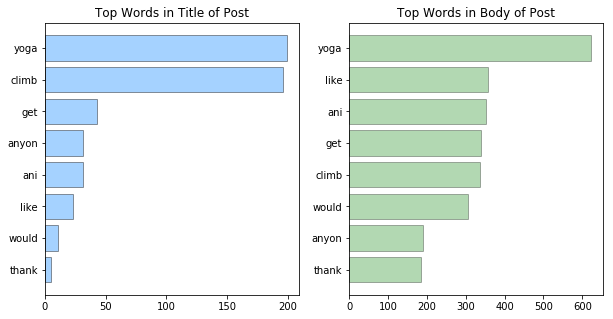

In [521]:
fig = plt.figure(figsize=(10,5))

ax1= fig.add_subplot(1,2,1)
ax1.barh(top5_title_df.index,top5_title_df['word_count'],color= 'dodgerblue',alpha=0.4,edgecolor='k');
ax1.set_title("Top Words in Title of Post")

ax1= fig.add_subplot(1,2,2)
ax1.barh(top5_body_df.index,top5_body_df['word_count'],color= 'green',edgecolor='k',alpha=0.3);
ax1.set_title("Top Words in Body of Post")

#### Combine vectorized features with length features

In [439]:
 X_train['selftext_len'].shape

(1139,)

In [440]:
X_train_merged = pd.concat([X_train_title_df,
                           X_train_body_df,
                           X_train['selftext_len']], axis=1)

In [441]:
X_test_merged = pd.concat([X_test_title_df,
                           X_test_body_df,
                           X_test['selftext_len']], axis=1)

In [442]:
X_test_merged.head()

,advic,ani,anyon,back,best,boulder,class,climb,climber,comp,...,whi,without,wonder,work,would,www,year,yoga,youtub,selftext_len
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,143
492,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
554,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,3,0,481
526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,431
1288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [443]:
X_train_merged.head()

,advic,ani,anyon,back,best,boulder,class,climb,climber,comp,...,whi,without,wonder,work,would,www,year,yoga,youtub,selftext_len
812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,95
662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,699
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,164
1171,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,640


### Modeling

#### Random Forest

In [529]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [530]:
X_train = X_train_merged
X_test = X_test_merged
y_train = y_train
y_test = y_test

In [531]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [532]:
rfc = RandomForestClassifier()
rf_params = {'max_depth': (5,10,15,20,25,30,35,40)}

gs = GridSearchCV(rfc, param_grid=rf_params)
gs.fit(X_train, y_train);

In [533]:
gs.best_params_

{'max_depth': 15}

In [534]:
gs.score(X_train,y_train)

0.9657594381035997

In [535]:
gs.score(X_test,y_test)

0.9526315789473684

In [537]:
rfc = RandomForestClassifier(max_depth = 15)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [538]:
rfc.score(X_train,y_train)

0.9648814749780509

In [539]:
rfc.score(X_test,y_test)

0.9552631578947368

#### K Nearest Neighbors

In [540]:
X_train_merged.columns

Index(['advic', 'ani', 'anyon', 'back', 'best', 'boulder', 'class', 'climb',
       'climber', 'comp',
       ...
       'whi', 'without', 'wonder', 'work', 'would', 'www', 'year', 'yoga',
       'youtub', 'selftext_len'],
      dtype='object', length=252)

For clarity, define X and y splits: 

In [541]:
X_train = X_train_merged
X_test = X_test_merged
y_train = y_train
y_test = y_test

In [542]:
len(y_train), len(y_test)


(1139, 380)

In [543]:
X_train.shape, X_test.shape

((1139, 252), (380, 252))

In [551]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [552]:
knn.score(X_train,y_train)

0.7655838454784899

In [553]:
knn.score(X_test,y_test)

0.7605263157894737

#### Tuning parameters:

In [547]:
ngbr = [5,10,12,14,16,18,20]
knn_score_list = []
knn_score_test_list = []
zero_count = []
for n in ngbr:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    score = knn.score(X_train,y_train).mean()
    knn_score_list.append(score)
    score_test= knn.score(X_test,y_test).mean()
    knn_score_test_list.append(score_test)
    knn_pred = knn.predict(X_test)
    zero_count.append(np.count_nonzero(knn_pred==0))

In [548]:
ngbr_df = pd.DataFrame()
ngbr_df['neighbors'] = ngbr
ngbr_df['train_accuracy_score']= knn_score_list
ngbr_df['test_accuracy_score']= knn_score_test_list

In [549]:
ngbr_df['preds_0'] = zero_count

In [554]:
ngbr_df[['neighbors','train_accuracy_score','test_accuracy_score']]

,neighbors,train_accuracy_score,test_accuracy_score
0,5,0.832309,0.765789
1,10,0.777875,0.757895
2,12,0.765584,0.760526
3,14,0.758560,0.763158
4,16,0.760316,0.784211
5,18,0.746269,0.752632
6,20,0.743635,0.752632


#### Logistic Regression

In [555]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [567]:
logreg = LogisticRegression(penalty='l1')

In [568]:
logreg.fit(X_train,y_train)
logreg.score(X_train,y_train)

0.9683933274802459

In [569]:
logreg.score(X_test,y_test)

0.9552631578947368

In [570]:
logreg = LogisticRegression(penalty='l2')

In [571]:
logreg.fit(X_train,y_train)
logreg.score(X_train,y_train)

0.9727831431079894

In [572]:
logreg.score(X_test,y_test)

0.9657894736842105

In [559]:
X_train.columns

Index(['advic', 'ani', 'anyon', 'back', 'best', 'boulder', 'class', 'climb',
       'climber', 'comp',
       ...
       'whi', 'without', 'wonder', 'work', 'would', 'www', 'year', 'yoga',
       'youtub', 'selftext_len'],
      dtype='object', length=252)

In [560]:
coefs_df = pd.DataFrame({'word': X_train.columns, 'coef_values': logreg.coef_[0]})
coefs_df['abs_values'] = abs(coefs_df['coef_values'])
coefs_df = coefs_df.sort_values('abs_values',ascending=False)

In [519]:
coefs_df.head(25)

,word,coef_values,abs_values
9,comp,-3.412056,3.412056
40,yoga,-3.236308,3.236308
249,yoga,-2.627884,2.627884
7,climb,2.364534,2.364534
71,climb,2.316618,2.316618
28,pose,-2.262215,2.262215
41,yogi,-1.670733,1.670733
184,practic,-1.538736,1.538736
5,boulder,1.300700,1.300700
181,pose,-1.130173,1.130173


In [482]:
over_seven = coefs_df['abs_values']>.9

In [520]:
c_val = coefs_df[over_seven][['coef_values']]
c_val_abs = coefs_df[over_seven][['abs_values']]

In [493]:
c_val_df = pd.DataFrame(c_val)
c_val_df['abs_value'] = c_val_abs

In [494]:
c_val_df.index = coefs_df[over_seven]['word'] 

In [495]:
c_val_df = c_val_df.sort_values('abs_value',ascending = False)

In [496]:
c_val_df['positive'] = c_val['coef_values'] > 0

In [497]:
c_val_df

,coef_values,abs_value,positive
word,,,
comp,-3.412056,3.412056,False
yoga,-3.236308,3.236308,False
yoga,-2.627884,2.627884,False
climb,2.364534,2.364534,True
climb,2.316618,2.316618,True
pose,-2.262215,2.262215,False
yogi,-1.670733,1.670733,False
practic,-1.538736,1.538736,False
boulder,1.300700,1.300700,True


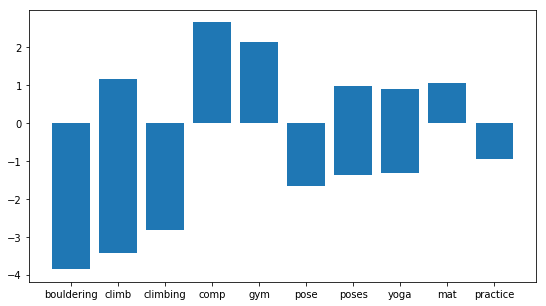

In [222]:
fig = plt.figure(figsize=(20,5))

ax1= fig.add_subplot(1,2,1)
ax1.bar(c_val.index, c_val_df['coef_values']);

#ax1= fig.add_subplot(1,2,2)
#ax1.barh(top5_body_df.index,top5_body_df['word_count'],color='green');

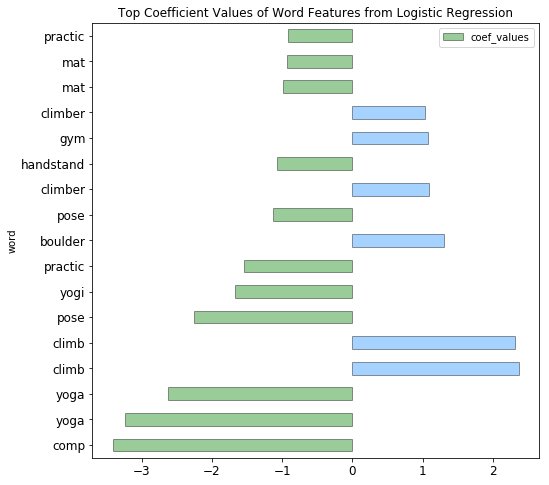

In [528]:

c_val_df['coef_values'].plot(kind='barh',
                             color=c_val_df.positive.map({True: 'dodgerblue', False: 'green'}),
                             alpha=0.4,figsize=(8,8),fontsize = 12,legend='coef values',edgecolor='k',
                             title="Top Coefficient Values of Word Features from Logistic Regression"); 
#colormap='coolwarm'


In [224]:
#coefs_df.to_csv('./reddit_data/logregcoefs.csv')